In [15]:
import sys, os
import serial
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import win32com.client
from astropy.io import fits
import threading
import nbimporter
from picoammeter_control import (
    send_cmd,
    query,
    init_cmds
)
from camera_control_ascom import (
    take_ramp,
    camera_init,
    populate_header
)
sys.path.insert(0, os.path.abspath('.'))
sys.path.insert(0, os.path.abspath('filter_wheel_control'))
from filter_wheel_control.wheel_controller import (
    list_devices,
    open_device,
    get_position,
    get_position_count,
    set_position,
    close_device
)
from data_helper_functions import (
    init_wheels,
    close_wheels,
    camera_init,
    picoam_stability,
    picoam_worker_exp,
    camera_with_picoam,
    collect_var_exp,
    var_exp_graphs,
    capture_frame,
    calculate_gain,
    get_gain,
    picoam_worker_filters,
    camera_with_filters,
    collect_var_filters,
    compare_exp_and_filter,
    collect_bias_frames
)

In [2]:
camera_init()
cam_name = "ASCOM.AtikCameras.Camera"
save_path= "C:/Users/Jonah/fits_imgs"

You selected: ASCOM.AtikCameras.Camera


In [3]:
min_exp = 0.001
max_exp = 5.0

KEITHLEY INSTRUMENTS INC.,MODEL 6485,4070587,C01   Jun 23 2010 12:22:00/A02  /H
relative std: 4.3497752958727345e-11


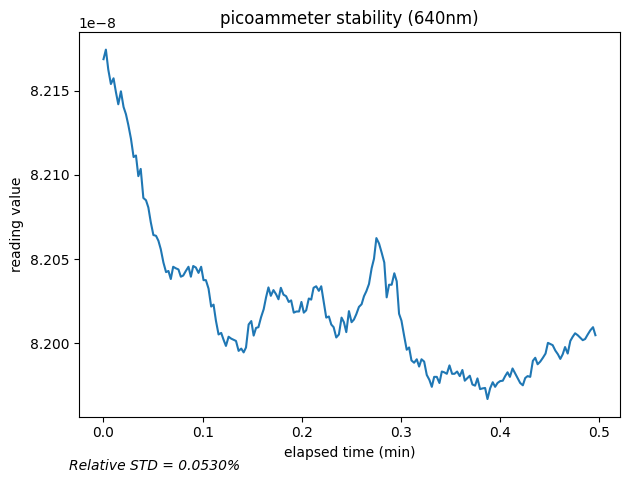

saved to path


In [16]:
picoam_stability(read_time = .5, save = save_path, port='COM5')

In [4]:
init_wheels(print_stuff=False)
close_wheels()

In [5]:
e_per_adu = get_gain(cam_name=cam_name, exp_time=min_exp, num_frames=3, print_stuff=True)

starting calculation
taking frame
taking frame
taking frame
flats collected
darks collected
Measured: 0.01957 e-/ADU on mode=176 gain
Flat mean: 990.3959453885498, Flat var: 6584.4
Dark mean: 969.6624966336514, Dark var: 5525.0


KEITHLEY INSTRUMENTS INC.,MODEL 6485,4070587,C01   Jun 23 2010 12:22:00/A02  /H
Camera connected: ASCOM.AtikCameras.Camera, Size: 9576x6380, Temperature: 27.37C
Taking frames at 0.00100000 seconds (exposure time 1/60)
Taking frames at 0.00115530 seconds (exposure time 2/60)
Taking frames at 0.00133472 seconds (exposure time 3/60)
Taking frames at 0.00154200 seconds (exposure time 4/60)
Taking frames at 0.00178147 seconds (exposure time 5/60)
Taking frames at 0.00205813 seconds (exposure time 6/60)
Taking frames at 0.00237775 seconds (exposure time 7/60)
Taking frames at 0.00274701 seconds (exposure time 8/60)
Taking frames at 0.00317362 seconds (exposure time 9/60)
Taking frames at 0.00366648 seconds (exposure time 10/60)
Taking frames at 0.00423588 seconds (exposure time 11/60)
Taking frames at 0.00489371 seconds (exposure time 12/60)
Taking frames at 0.00565370 seconds (exposure time 13/60)
Taking frames at 0.00653172 seconds (exposure time 14/60)
Taking frames at 0.00754609 seconds 

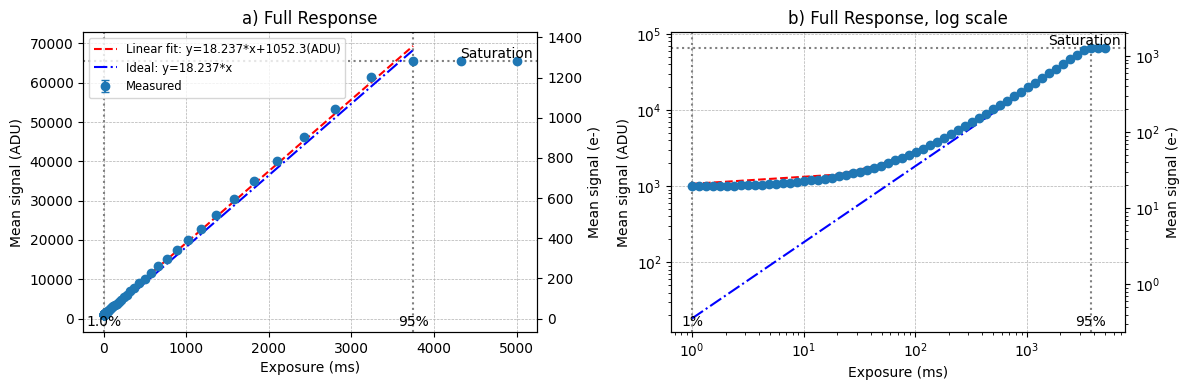

Figure saved to exp_0.001-5.0_linearity_figure.png


In [11]:
I_flat, Q_ramp, mean_signal, std_signal, bit_depth, exp_times, exp_low, exp_high, exp_50 = (
    collect_var_exp(cam_name=cam_name, num_exp=60, num_frames=10, exp_low = min_exp, exp_high = max_exp, save_path=save_path, offset=0)
)

var_exp_graphs(mean_signal, std_signal, bit_depth, exp_times, exp_low, exp_high, save=True, e_per_adu=e_per_adu, min_percent=0.01, percent_change=False)

In [7]:
signals_f, Q_filt = collect_var_filters(save_path = save_path, cam_name=cam_name, exp_50=exp_50, num_frames=10, offset=0)


starting filter 1
starting filter 2
starting filter 3
starting filter 4
starting filter 5
starting filter 6
Wrote per-frame filter data to C:/Users/Jonah/fits_imgs\filter_frame_data.csv
finished


In [10]:
bias_level = collect_bias_frames(cam_name = cam_name,num_frames=500, exp_low=min_exp, save_path=save_path, offset=0)
print("bias level: ", bias_level)

Camera connected: ASCOM.AtikCameras.Camera, Size: 9576x6380, Temperature: 26.40C
Taking frames at 0.00100000 seconds (exposure time 1/1)
exp res: 0.00100000 seconds
Bias cube saved to C:/Users/Jonah/fits_imgs\bias_stack.fits
Bias means saved to C:/Users/Jonah/fits_imgs\bias_means.csv
bias level:  972.9270201139999


972.9270201139999
Figure saved to exp_vs_filter_figure.png


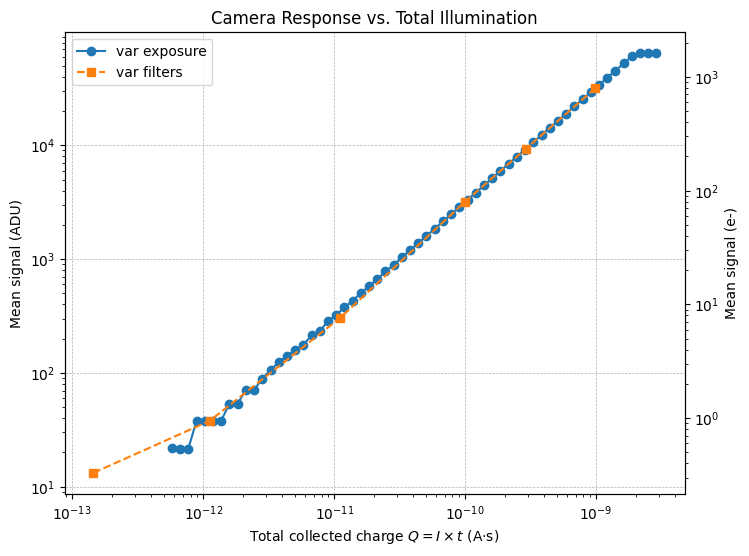

In [12]:
compare_exp_and_filter(e_per_adu = .025, Q_ramp=Q_ramp, Q_filt=Q_filt, signals_f=signals_f, mean_signal=mean_signal, bias_level=bias_level, save=True)
